In [1]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
from torchvision.models import resnet101
from advertorch.utils import predict_from_logits
from advertorch.utils import NormalizeByChannelMeanStd

normalize = NormalizeByChannelMeanStd(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = resnet101(pretrained=True)
model.eval()
model = nn.Sequential(normalize, model)
model = model.to(device)

In [3]:
from advertorch_examples.utils import ImageNetClassNameLookup
from advertorch_examples.utils import get_panda_image
from advertorch_examples.utils import bhwc2bchw
from advertorch_examples.utils import bchw2bhwc


np_img = get_panda_image()
img = torch.tensor(bhwc2bchw(np_img))[None, :, :, :].float().to(device)
label = torch.tensor([388, ]).long().to(device)
imagenet_label2classname = ImageNetClassNameLookup()

In [4]:
from advertorch.attacks import LinfPGDAttack

adversary = LinfPGDAttack(
    model, eps=1. / 255, eps_iter=0.25 / 255, nb_iter=10,
    rand_init=False, targeted=False)

advimg = adversary.perturb(img, label)

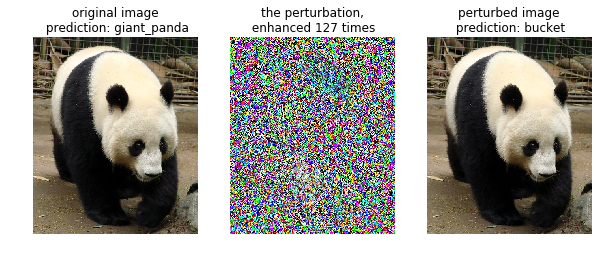

In [5]:
def tensor2npimg(tensor):
    return bchw2bhwc(tensor[0].cpu().numpy())

np_advimg = tensor2npimg(advimg)
np_perturb = tensor2npimg(advimg - img)

pred = imagenet_label2classname(predict_from_logits(model(img)))
advpred = imagenet_label2classname(predict_from_logits(model(advimg)))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(np_img)
plt.axis("off")
plt.title("original image\n prediction: {}".format(pred))
plt.subplot(1, 3, 2)
plt.imshow(np_perturb * 127 + 0.5)
plt.axis("off")
plt.title("the perturbation,\n enhanced 127 times".format(pred))
plt.subplot(1, 3, 3)
plt.imshow(np_advimg)
plt.axis("off")
plt.title("perturbed image\n prediction: {}".format(advpred))
plt.show()
